This dataset is imported from https://nijianmo.github.io/amazon/index.html with 147,194 customers' reviews on the gift cards. It contains reviews with the overall rating from from 1.0 to 5.0, with 1.0 is highly negative and 5.0 is highly positive. It contains 13 following columns:
    
overall - rating of the product

vote- how many time the customer is voted

verified- whether the customer's account is verified

reviewTime - time of the review (raw)

unixReviewTime - time of the review (unix time)

reviewerID - ID of the reviewer, e.g. A1RSDE90N6RSZF

asin - ID of the product, e.g. 0000013714

style- the description of the product

reviewerName - name of the reviewer

reviewText - text of the review

summary - summary of the review

unixReviewTime - time of the review (raw)

image - url of the product image

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Libraries

In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
import itertools
#libraries to open the dataset
import json
import gzip
#Specific library for NLP needs
import nltk
import nltk.corpus
from nltk.tokenize import word_tokenize,RegexpTokenizer
from nltk.stem import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import re 
# for text processing
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
# for class imbalance
from imblearn.over_sampling import BorderlineSMOTE, SMOTE, ADASYN, SMOTENC, RandomOverSampler
# for modelling
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score, precision_score, classification_report, cohen_kappa_score
import itertools
# for neural network
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
#Validation set and Cross validation 
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

nltk.download('all')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

True

# Obtain the dataset

In [5]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

data = getDF('/content/drive/MyDrive/Amazon_reviews_analysis/Gift_Cards.json.gz')

Make a copy of the dataset

In [6]:
df=data.copy()

In [7]:
df.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,1.0,25,False,"12 19, 2008",APV13CM0919JD,B001GXRQW0,{'Gift Amount:': ' 50'},LEH,"Amazon,\nI am shopping for Amazon.com gift car...",Merry Christmas.,1229644800,NaN
1,5.0,NaN,False,"12 17, 2008",A3G8U1G1V082SN,B001GXRQW0,{'Gift Amount:': ' 50'},Tali,"I got this gift card from a friend, and it was...",Gift card with best selection,1229472000,NaN
2,5.0,4,False,"12 17, 2008",A11T2Q0EVTUWP,B001GXRQW0,{'Gift Amount:': ' 50'},Z,aren't we going to save trees?! :) People who ...,A convenient and great gift for the environmen...,1229472000,NaN
3,5.0,NaN,False,"12 17, 2008",A9YKGBH3SV22C,B001GXRQW0,{'Gift Amount:': ' 25'},Giotravels,You can always get someone something from Amaz...,Totally make sense,1229472000,NaN
4,1.0,NaN,True,"12 17, 2008",A34WZIHVF3OKOL,B001GXRQW0,NaN,King Dad,Why take 50 dollars of good money with no limi...,Give CASH!,1229472000,NaN


We are only interested in 'reviewText' which will be our independent variable and 'overall' which will be our dependent variable in our sentimental analysis



In [8]:
df = pd.concat([df.overall, df.reviewText],axis=1)

In [9]:
df.shape

(147194, 2)

This dataset contains of 147194 reviews

# Data Exploration/Data Cleaning

In [10]:
#check data types if they are correct
df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147194 entries, 0 to 147193
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   overall     147194 non-null  float64
 1   reviewText  147035 non-null  object 
dtypes: float64(1), object(1)
memory usage: 3.4+ MB


In [11]:
#drop duplicates
df = df.drop_duplicates()

In [12]:
df.shape

(122580, 2)

In [13]:
#check NAN value
for i in df.columns:
    print('The number of missing value in',i,'is:   ',df[i].isnull().sum())

The number of missing value in overall is:    0
The number of missing value in reviewText is:    3


As we need the information of the 'reviewText' to predict 'overall', we will drop the rows where the reviewText is missing

In [14]:
df=df.dropna(subset=['reviewText'])

In [15]:
df.shape

(122577, 2)

After cleaning the dataset, we have 122,577 unique values for prediction

### Target variable

In [16]:
y = df['overall']

We will have an overview of 'overall', it will be our target value

In [17]:
print(df['overall'].value_counts())

print(df['overall'].value_counts(normalize=True) * 100)

5.0    103134
4.0      7872
1.0      7052
3.0      2886
2.0      1633
Name: overall, dtype: int64
5.0    84.138134
4.0     6.422086
1.0     5.753118
3.0     2.354438
2.0     1.332224
Name: overall, dtype: float64


For the sake of the sentimental analysis, we will bin our 'overall' values into 3 categories, where '5,0' and '4.0' would be 'Positive' ; '3.0' would be 'Neutral' ;  '2.0' and '1.0' would be 'Negative'. Also we change the columns 'overall' to 'sentiments' so it makes more sense in our analysis

In [18]:
df['overall']=df['overall'].replace([5.0,4.0,3.0,2.0,1.0],['Positive','Positive','Neutral','Negative','Negative'])
df=df.rename(columns = {'overall':'sentiments'})
df.head()

,sentiments,reviewText
0,Negative,"Amazon,\nI am shopping for Amazon.com gift car..."
1,Positive,"I got this gift card from a friend, and it was..."
2,Positive,aren't we going to save trees?! :) People who ...
3,Positive,You can always get someone something from Amaz...
4,Negative,Why take 50 dollars of good money with no limi...


In [19]:
#pd.set_option('display.max_rows', 500)
#pd.set_option('display.max_colwidth', -1)
#df[df['sentiments']=='Negative'].iloc[169:172]

In [20]:
print(df['sentiments'].value_counts())
print(df['sentiments'].value_counts(normalize=True))

Positive    111006
Negative      8685
Neutral       2886
Name: sentiments, dtype: int64
Positive    0.905602
Negative    0.070853
Neutral     0.023544
Name: sentiments, dtype: float64


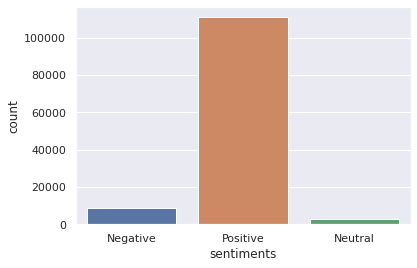

In [21]:
ax = sns.countplot(data=df,x ='sentiments')# estimator=lambda x: len(x) / len(df) * 100)
#ax.set(ylabel="Percent")

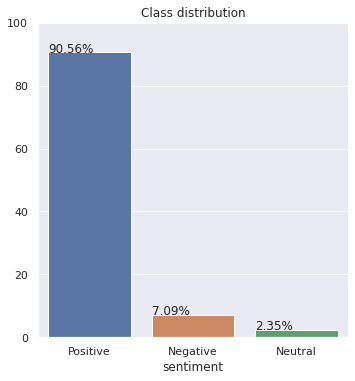

In [22]:
df1 = df['sentiments'].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.reset_index()
df1.columns = ['sentiment','percentage']
df1

g = sns.catplot(x='sentiment',y='percentage',kind='bar',data=df1)
g.ax.set_ylim(0,100)


for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x()
    #txt_x = ['Postive','Negative','Neutral']
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)
    g.set(ylabel=None,title="Class distribution")

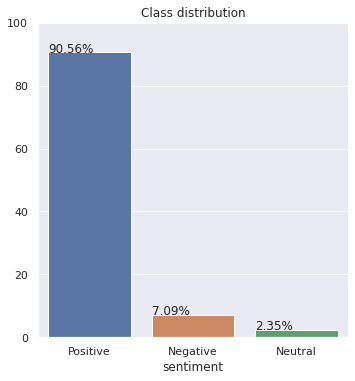

In [23]:
df1 = df['sentiments'].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.reset_index()
df1.columns = ['sentiment','percentage']
df1

g = sns.catplot(x='sentiment',y='percentage',kind='bar',data=df1)
g.ax.set_ylim(0,100)


for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x()
    #txt_x = ['Postive','Negative','Neutral']
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)
    g.set(ylabel=None,title="Class distribution")

We can see a huge imbalance between the sentiments, 90% of which are 'Positive'. The customers who do not have 'neutral' sentiment towards the products are least likely to give reviews.

# Text Processing

The standard text mining procedures are to extract useful features from the news contents, including tokenization, removing stopwords, and lemmatization.

## Tokenziation

The first step of text processing is tokenization, which breaks a stream of text up into meaningful elements called tokens.

In [24]:
# get example of 1 review
df['reviewText'][0]

'Amazon,\nI am shopping for Amazon.com gift cards for Christmas gifts and am really so disappointed that out of five choices there isn\'t one that says "Merry Christmas" or mentions Christmas at all!  I am sure I am not alone in wanting a card that reflects the actual "holiday" we are celebrating. On principle, I cannot send a Amazon gift card this Christmas.  What\'s up with all the Political Correctness?  Bad marketing decision.\nLynn'

In [25]:
from nltk.tokenize import word_tokenize, RegexpTokenizer
def word_tokenize(text):
  tokenizer = RegexpTokenizer(r'\w+')
  toks = tokenizer.tokenize(text) # Result of tokenizing the first review
  #text_token = ' '.join(words for words in toks)
  return toks


In [26]:
word_tokenize(df['reviewText'][0])

['Amazon',
 'I',
 'am',
 'shopping',
 'for',
 'Amazon',
 'com',
 'gift',
 'cards',
 'for',
 'Christmas',
 'gifts',
 'and',
 'am',
 'really',
 'so',
 'disappointed',
 'that',
 'out',
 'of',
 'five',
 'choices',
 'there',
 'isn',
 't',
 'one',
 'that',
 'says',
 'Merry',
 'Christmas',
 'or',
 'mentions',
 'Christmas',
 'at',
 'all',
 'I',
 'am',
 'sure',
 'I',
 'am',
 'not',
 'alone',
 'in',
 'wanting',
 'a',
 'card',
 'that',
 'reflects',
 'the',
 'actual',
 'holiday',
 'we',
 'are',
 'celebrating',
 'On',
 'principle',
 'I',
 'cannot',
 'send',
 'a',
 'Amazon',
 'gift',
 'card',
 'this',
 'Christmas',
 'What',
 's',
 'up',
 'with',
 'all',
 'the',
 'Political',
 'Correctness',
 'Bad',
 'marketing',
 'decision',
 'Lynn']

## Stopwords handling

Example of words are ’the, ’is’, ’and’, ’what’, etc. that are somewhat irrelevant to text sentiment and don't provide any valuable information. These are called stopwords. We will remove them from our reviews

In [27]:
#get the list of stopwords in English
stop_words = stopwords.words('english')
print(stop_words[:20])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his']


## Lemmatization

The process of reducing different forms of a word to a core root. For example the words “ask” and “asked” are just different tenses of the same verb. The lemmatization will reduce 'asked' to 'ask. Lemmatisation is closely related to stemming. The difference is that a stemmer operates on a single word without knowledge of the context, and therefore cannot discriminate between words which have different meanings depending on part of speech. In our case I will use lemmatization. 

In [28]:
def lemmatization(text):
    lm = WordNetLemmatizer()
    text_lemmatized=' '.join([lm.lemmatize(word) for word in text.split()])
    return text_lemmatized

In [29]:
#test the function on the first review
lemmatization(df['reviewText'][0])

'Amazon, I am shopping for Amazon.com gift card for Christmas gift and am really so disappointed that out of five choice there isn\'t one that say "Merry Christmas" or mention Christmas at all! I am sure I am not alone in wanting a card that reflects the actual "holiday" we are celebrating. On principle, I cannot send a Amazon gift card this Christmas. What\'s up with all the Political Correctness? Bad marketing decision. Lynn'

## Function for Preprocessing

In [30]:
def text_processing(text):
  words = word_tokenize(text)
  toks = [word.lower() for word in words if word.lower() not in stop_words and len(word) > 1]
  #toks = [t.lower() for t in tokenizer if t.lower() not in stop_words if t != '' if len(t) > 1]
  text_token = ' '.join(words for words in toks)
  text_clean = lemmatization(text_token) 
  
  return text_clean

In [31]:
text_processing(df['reviewText'][0])

'amazon shopping amazon com gift card christmas gift really disappointed five choice one say merry christmas mention christmas sure alone wanting card reflects actual holiday celebrating principle cannot send amazon gift card christmas political correctness bad marketing decision lynn'

## Text-processed Dataset

In [32]:
# apply function to the dataset to get a clean preprocessed dataset
df['reviewText'] = df['reviewText'].apply(lambda x:text_processing(x))

In [349]:
df.head()

,sentiments,reviewText
0,Negative,amazon shopping amazon com gift card christmas gift really disappointed five choice one say merry christmas mention christmas sure alone wanting card reflects actual holiday celebrating principle cannot send amazon gift card christmas political correctness bad marketing decision lynn
1,Positive,got gift card friend best site much choose great gift
2,Positive,going save tree people complaining paper gift card simply buy electronic gift card via email convenient indeed great gift found paper gift card annoying since always wonder much money got left lose lose electronic delivery gift card make lot easier redeem need copy paste code gift certificate balance whenever want use sent friend electronic gift card via email newborn wedding housewarming happy holiday
3,Positive,always get someone something amazon safety net return like returning thing hassle card take care return hassle
4,Negative,take 50 dollar good money limitation turn amazon money used site benefit also spend time headache buying type card dealing activation issue risking expiration delivery issue keep keep track much remaining card least give discount committing purchasing power


Now we will use this dataset for modelling

###'Positive' Reviews

We can grab all 'Positive' reviews from our dataframe, hand them over to our function, then call NLTK's `FreqDist` function to get the most common words in the positive reviews:

In [350]:
 def process_text(reviews):
    tokens = []
    for line in reviews:
        tokenizer = RegexpTokenizer(r'\w+') # this tokenizer ONLY looks at WORDS
        toks = tokenizer.tokenize(line) # break the reviews into words
        toks = [t.lower() for t in toks if t.lower() not in stop_words and len(t) > 1] #bring all the words in lower case and get rid of stop words
                                                                                       #filter out short tokens
        tokens.extend(toks) # add all the final tokens in the list tokens
                            # use extend will add all tokens into ONE SINGLE list
        
    return tokens

In [38]:
pos_rev = list(df[df['sentiments'] == 'Positive']['reviewText'].values)
#pos_rev
#tokens_pos = [text_processing(review) for review in pos_rev ]
#tokens_pos[0:10]
tokens_pos = process_text(pos_rev)
freq_pos = nltk.FreqDist(tokens_pos)
freq_pos.most_common(50) # shows 50 most common positive words

[('gift', 83590),
 ('card', 58437),
 ('amazon', 25173),
 ('great', 21544),
 ('easy', 19394),
 ('love', 15159),
 ('way', 9949),
 ('perfect', 9881),
 ('get', 9669),
 ('loved', 9428),
 ('use', 8452),
 ('like', 7853),
 ('buy', 7849),
 ('time', 7566),
 ('give', 7529),
 ('birthday', 6794),
 ('one', 6687),
 ('always', 6588),
 ('nice', 6431),
 ('purchase', 6419),
 ('good', 6402),
 ('christmas', 6401),
 ('want', 6109),
 ('send', 6006),
 ('recipient', 5690),
 ('would', 5343),
 ('go', 5084),
 ('cute', 5047),
 ('fast', 4890),
 ('happy', 4873),
 ('friend', 4802),
 ('day', 4776),
 ('really', 4718),
 ('make', 4631),
 ('got', 4499),
 ('box', 4479),
 ('able', 4427),
 ('received', 4411),
 ('minute', 4410),
 ('quick', 4152),
 ('someone', 4044),
 ('know', 3976),
 ('thank', 3829),
 ('well', 3821),
 ('arrived', 3752),
 ('email', 3749),
 ('could', 3694),
 ('much', 3678),
 ('family', 3627),
 ('convenient', 3616)]

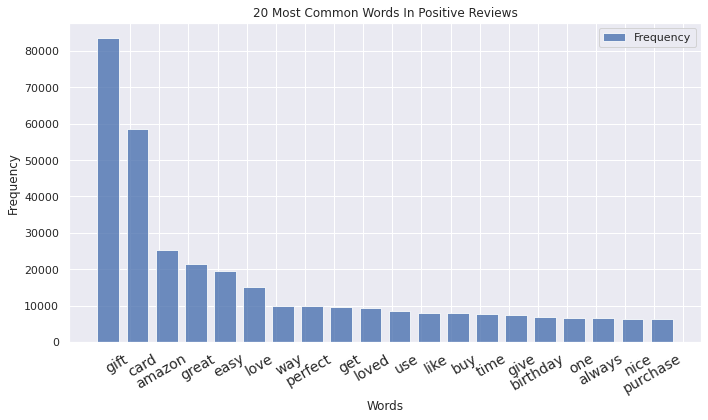

In [276]:
n_groups = len(freq_pos.most_common(20))

vals_pos = [x[1] for x in freq_pos.most_common(20)]
legends_pos = [x[0] for x in freq_pos.most_common(20)]

#fig, ax = plt.subplots()
fig = plt.figure(figsize=(10,6)) #sets a different size (inches wide, inches tall)
ax = plt.subplot(111)
index = np.arange(n_groups)
bar_width = 0.75
opacity = 0.8

rects1 = plt.bar(index, vals_pos, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Frequency')


plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('20 Most Common Words In Positive Reviews')
plt.xticks(index + bar_width, legends_pos,fontsize=14)
fig.autofmt_xdate()
plt.legend()

plt.tight_layout()
plt.show()

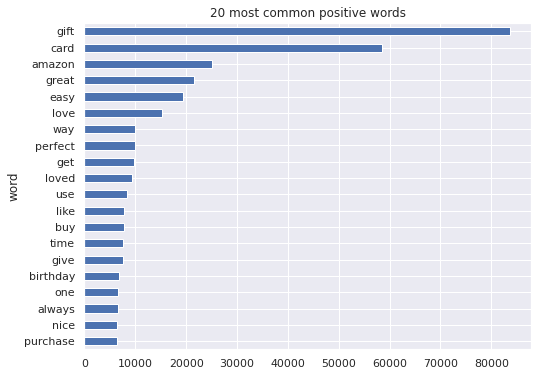

In [301]:
freq_pos_df = pd.DataFrame(freq_pos.most_common(20))
freq_pos_df.columns = ['word','count']
freq_pos_df.set_index('word', inplace=True)
freq_pos_df.sort_values('count',ascending=True,inplace=True)
freq_pos_df['count'].plot(kind="barh", figsize=(8,6),title="20 most common positive words")

We can see the most frequent words are 'gift','card', 'amazon'. It is obviously correct as the customers always refer to the product and the site's name when they give a review. They will predictably common in any other 'overall' categories. 

We will repeat the process to get the most 50 common word in the other categories.

### 'Neutral' Reviews

In [40]:
neu_reviews = list(df[df['sentiments'] == 'Neutral']['reviewText'].values)
neu_tokens = process_text(neu_reviews)
freq_neu = nltk.FreqDist(neu_tokens)
freq_neu.most_common(50)

[('card', 3081),
 ('gift', 2519),
 ('amazon', 794),
 ('would', 488),
 ('one', 432),
 ('time', 419),
 ('get', 363),
 ('use', 359),
 ('sent', 320),
 ('box', 316),
 ('received', 302),
 ('like', 301),
 ('recipient', 279),
 ('could', 250),
 ('day', 248),
 ('purchase', 247),
 ('know', 244),
 ('order', 241),
 ('great', 229),
 ('got', 226),
 ('email', 211),
 ('message', 210),
 ('good', 204),
 ('ordered', 199),
 ('buy', 191),
 ('birthday', 189),
 ('nice', 182),
 ('work', 181),
 ('give', 180),
 ('make', 169),
 ('way', 169),
 ('arrived', 169),
 ('print', 166),
 ('used', 165),
 ('however', 164),
 ('send', 162),
 ('really', 154),
 ('came', 150),
 ('problem', 149),
 ('mail', 146),
 ('sure', 142),
 ('took', 139),
 ('little', 133),
 ('able', 132),
 ('fine', 132),
 ('easy', 132),
 ('person', 129),
 ('never', 128),
 ('account', 128),
 ('bought', 124)]

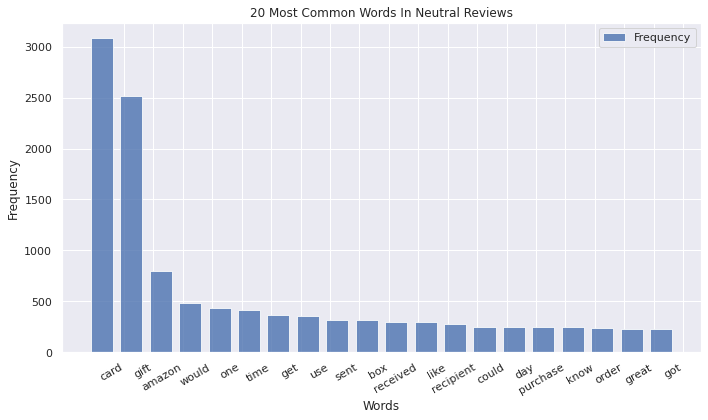

In [95]:
n_groups = len(freq_neu.most_common(20))

vals_neu = [x[1] for x in freq_neu.most_common(20)]
legends_neu = [x[0] for x in freq_neu.most_common(20)]
fig = plt.figure(figsize=(10,6)) #sets a different size (inches wide, inches tall)
ax = plt.subplot(111)
#fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.75

opacity = 0.8

rects1 = plt.bar(index, vals_neu, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Frequency')


plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('20 Most Common Words In Neutral Reviews')
plt.xticks(index + bar_width, legends_neu)
fig.autofmt_xdate()
plt.legend()

plt.tight_layout()
plt.show()

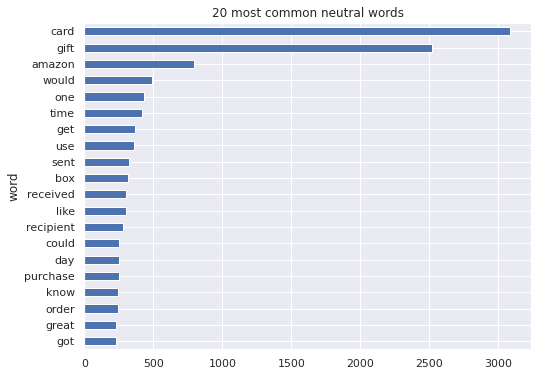

In [302]:
freq_neu_df = pd.DataFrame(freq_neu.most_common(20))
freq_neu_df.columns = ['word','count']
freq_neu_df.set_index('word', inplace=True)
freq_neu_df.sort_values('count',ascending=True,inplace=True)
freq_neu_df['count'].plot(kind="barh", figsize=(8,6),title="20 most common neutral words")

### 'Negative' Reviews

In [46]:
review_neg = list(df[df['sentiments'] == 'Negative']['reviewText'].values)
tokens_neg = process_text(review_neg)
freq_neg = nltk.FreqDist(tokens_neg)
freq_neg.most_common(20)
#(freq_neg.most_common(20))

[('card', 11464),
 ('gift', 8692),
 ('amazon', 3717),
 ('use', 1953),
 ('one', 1625),
 ('would', 1582),
 ('get', 1544),
 ('time', 1370),
 ('never', 1207),
 ('received', 1144),
 ('buy', 1116),
 ('sent', 1080),
 ('work', 1048),
 ('day', 1034),
 ('purchase', 1031),
 ('order', 1025),
 ('could', 985),
 ('money', 894),
 ('email', 864),
 ('ordered', 862)]

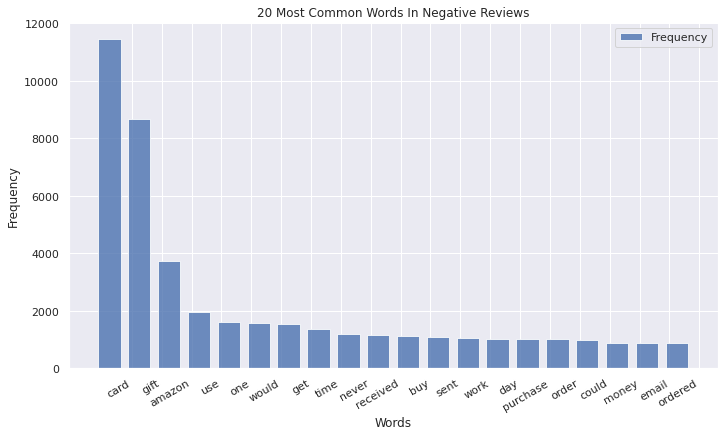

In [93]:
n_groups = len(freq_neg.most_common(20))

vals_neg = [x[1] for x in freq_neg.most_common(20)]
legends_neg = [x[0] for x in freq_neg.most_common(20)]

fig = plt.figure(figsize=(10,6)) #sets a different size (inches wide, inches tall)
ax = plt.subplot(111)
#fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.75

opacity = 0.8

rects1 = plt.bar(index, vals_neg, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Frequency')


plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('20 Most Common Words In Negative Reviews')
plt.xticks(index + bar_width, legends_neg)
fig.autofmt_xdate()
plt.legend()

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

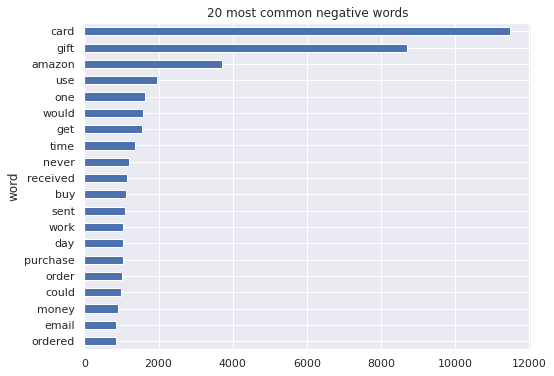

In [303]:
freq_neg_df = pd.DataFrame(freq_neg.most_common(20))
freq_neg_df.columns = ['word','count']
freq_neg_df.set_index('word', inplace=True)
freq_neg_df.sort_values('count',ascending=True,inplace=True)
freq_neg_df['count'].plot(kind="barh", figsize=(8,6),title="20 most common negative words")

### Visualize the words distribution

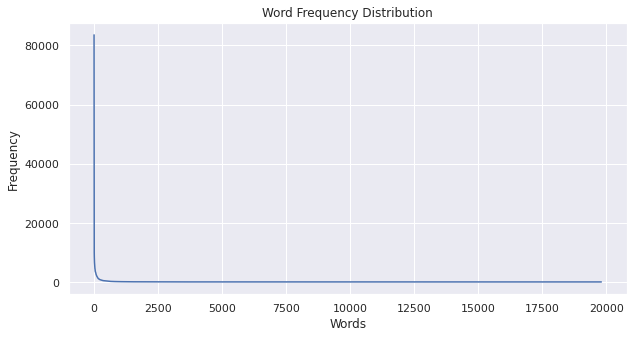

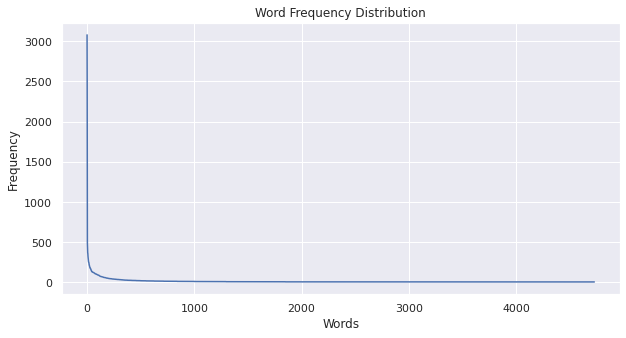

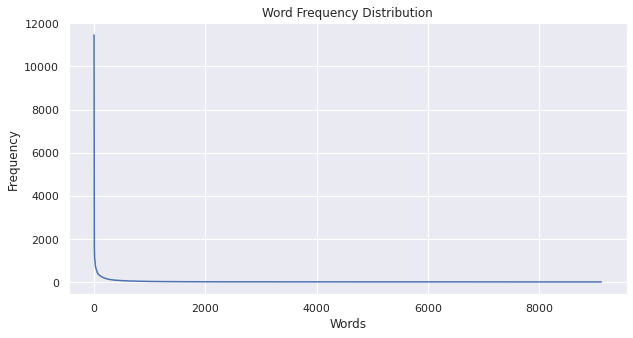

In [ ]:
import matplotlib.pyplot as plt
freq_list = [freq_pos.most_common(),freq_neu.most_common(),freq_neg.most_common()]
for i in range(len(freq_list)):
  y_val = [x[1] for x in freq_list[i]]
  fig = plt.figure(figsize=(10,5))
  plt.plot(y_val)
  plt.xlabel("Words")
  plt.ylabel("Frequency")
  plt.title("Word Frequency Distribution")
  plt.show()

The plot shows that in our word distribution a vast minority of the words appear the most, while the majority of words appear less.

# Modelling

## Train-test split

In [33]:
from sklearn.model_selection import train_test_split

X = df['reviewText']
y = df['sentiments']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

## Approach 1: Unigrams Modeling

We create a Pipeline object that transforms the input data into a matrix of TF-IDF features and classifies the test data using different classifying model

In [34]:
#Create function that plot the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=20)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=15)
    plt.xlabel('Predicted label', fontsize=15)


    return plt

In [37]:
def model_count_tfidf(classifier, X_train, y_train, X_test,y_test):
#     for n in classifier:
    pipe = Pipeline([
    ('bow',CountVectorizer()),
    ('tfidf',TfidfTransformer()),
    ('classifier',classifier())])

    pipe.fit(X_train,y_train)
    pred = pipe.predict(X_test)
    cm = confusion_matrix(y_test,pred)


    print(f'The classifier is {classifier()}','\n')
    print(classification_report(y_test,pred))
    print('The Kappa score is {:4.2f}'.format(cohen_kappa_score(y_test,pred)))
    
    fig = plt.figure(figsize=(5, 5))
    plot = plot_confusion_matrix(cm, classes=['Negative','Neutral','Positive'], normalize=False, title='Confusion matrix')
    plt.show()

### Logistic Regression

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


The classifier is LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) 

              precision    recall  f1-score   support

    Negative       0.76      0.60      0.67      2167
     Neutral       0.39      0.03      0.05       717
    Positive       0.95      0.99      0.97     27761

    accuracy                           0.94     30645
   macro avg       0.70      0.54      0.57     30645
weighted avg       0.93      0.94      0.93     30645

The Kappa score is 0.59


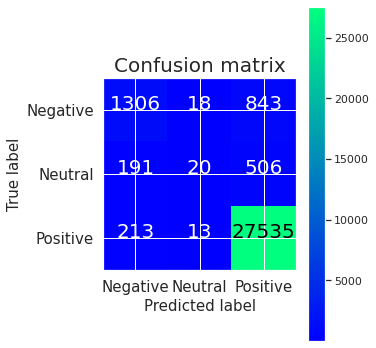

In [38]:
model_count_tfidf(LogisticRegression, X_train, y_train, X_test, y_test)

### Naive Bayes

The classifier is MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) 

              precision    recall  f1-score   support

    Negative       0.90      0.21      0.34      2267
     Neutral       0.00      0.00      0.00       688
    Positive       0.92      1.00      0.96     27690

    accuracy                           0.92     30645
   macro avg       0.61      0.40      0.43     30645
weighted avg       0.90      0.92      0.89     30645

The Kappa score is 0.26


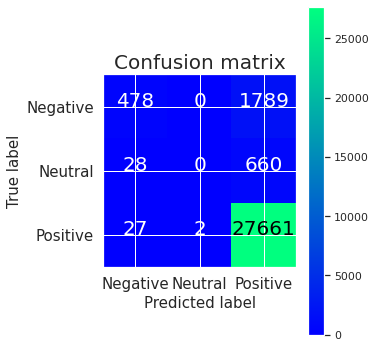

In [388]:
model_count_tfidf(MultinomialNB,X_train, y_train, X_test, y_test)

### Random Forest

The classifier is RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False) 

              precision    recall  f1-score   support

    Negative       0.82      0.36      0.50      2167
     Neutral       0.36      0.01      0.01       717
    Positive       0.93      1.00      0.96     27761

    accuracy                           0.93     30645
   macro avg       0.70      0.46      0.49     30645
weighted avg       0.91      0.93      0.91     30645

The Kappa score is 0.40


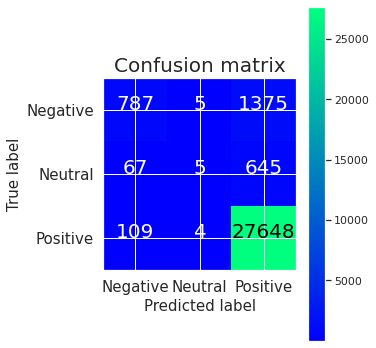

In [48]:
model_count_tfidf(RandomForestClassifier,X_train, y_train, X_test, y_test)

With our imbalanced dataset, logistic regression is performing the best, in terms of Kappa score, accuracy, and the f-1 score, precision score and recall score is also higher in the minority classes('negative','neutral') compared to the other models. The confusion matrix also shows that Logistic model predicts Negative and Neutral better than the other models

## Approach 2: Bigrams Modeling

In [354]:
def bigrams(classifier, X_train, y_train, X_test,y_test):
#     for n in classifier:
    pipe = Pipeline([
    ('bow',CountVectorizer(ngram_range = (1,2))),
    ('tfidf',TfidfTransformer()),
    ('classifier',classifier())])

    pipe.fit(X_train,y_train)
    pred = pipe.predict(X_test)
    cm = confusion_matrix(y_test,pred)


    print(f'The classifier is {classifier()}','\n')
    print(classification_report(y_test,pred))
    print('The Kappa score is {:4.2f}'.format(cohen_kappa_score(y_test,pred)))
    
    fig = plt.figure(figsize=(5, 5))
    plot = plot_confusion_matrix(cm, classes=['Negative','Neutral','Positive'], normalize=False, title='Confusion matrix')
    plt.show()

### Logistic Regression

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


The classifier is LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) 

              precision    recall  f1-score   support

    Negative       0.76      0.60      0.67      2149
     Neutral       0.36      0.01      0.02       728
    Positive       0.95      0.99      0.97     27768

    accuracy                           0.94     30645
   macro avg       0.69      0.53      0.55     30645
weighted avg       0.92      0.94      0.93     30645

The Kappa score is 0.58


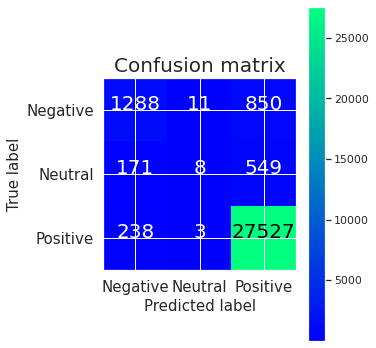

In [152]:
bigrams(LogisticRegression, X_train, y_train, X_test, y_test)

### Naive Bayes

The classifier is MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) 



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    Negative       1.00      0.00      0.01      2159
     Neutral       0.00      0.00      0.00       735
    Positive       0.91      1.00      0.95     27751

    accuracy                           0.91     30645
   macro avg       0.64      0.33      0.32     30645
weighted avg       0.89      0.91      0.86     30645

The Kappa score is 0.00632284547722084


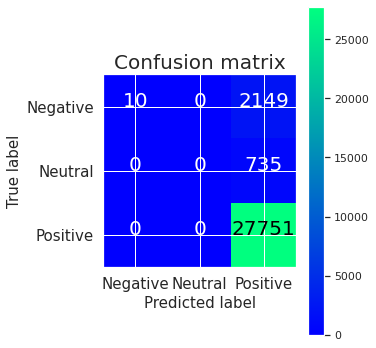

In [ ]:
bigrams(MultinomialNB,X_train, y_train, X_test, y_test)

### Random Forest

The classifier is RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False) 

              precision    recall  f1-score   support

    Negative       0.84      0.26      0.40      2105
     Neutral       0.21      0.01      0.01       736
    Positive       0.93      1.00      0.96     27804

    accuracy                           0.92     30645
   macro avg       0.66      0.42      0.46     30645
weighted avg       0.90      0.92      0.90     30645

The Kappa score is 0.30536738564425414


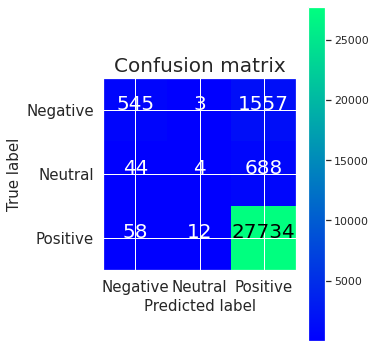

In [ ]:
bigrams(RandomForestClassifier,X_train, y_train, X_test, y_test)

Same like Unigrams with logistic regression, Bigrams with logistic regression is performing the best, in terms of Kappa score, accuracy, and the f-1 score, precision score and recall score is also higher in the minority classes('negative','neutral') compared to the other models. The confusion matrix also shows that Logistic model predicts Negative and Neutral better than the other models

# Improving the model

## Deal with the imbalance

### Manual class Balancing

1st balance

In [39]:
y_train.value_counts()

Positive    83245
Negative     6518
Neutral      2169
Name: sentiments, dtype: int64

In [40]:
df_train=pd.concat([X_train,y_train],axis=1)

In [357]:
df_new_pos_train = df_train[df_train['sentiments'] == 'Positive'].sample(df_train['sentiments'].value_counts()['Negative'])
df_new_neg_train = df_train[df_train['sentiments'] == 'Negative']
df_new_neu_train = df_train[df_train['sentiments'] == 'Neutral'].sample(df_train['sentiments'].value_counts()['Negative'], replace = True)


In [358]:
df_train_final = pd.concat([df_new_pos_train, df_new_neg_train, df_new_neu_train], axis = 0)
print(df_train_final['sentiments'].value_counts()) 

Neutral     6418
Positive    6418
Negative    6418
Name: sentiments, dtype: int64


In [359]:
X_train_balance = df_train_final['reviewText']
y_train_balance = df_train_final['sentiments']

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


The classifier is LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) 

              precision    recall  f1-score   support

    Negative       0.46      0.76      0.58      2267
     Neutral       0.08      0.45      0.14       688
    Positive       0.99      0.82      0.90     27690

    accuracy                           0.81     30645
   macro avg       0.51      0.68      0.54     30645
weighted avg       0.93      0.81      0.86     30645

The Kappa score is 0.3858084812375645


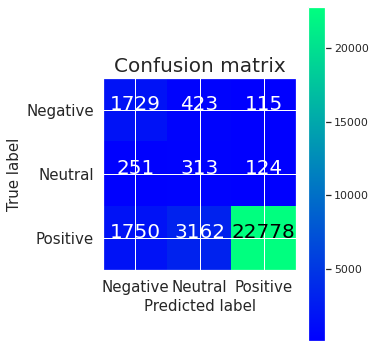

In [360]:
model_count_tfidf(LogisticRegression, X_train_balance, y_train_balance, X_test, y_test)

The classifier is MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) 

              precision    recall  f1-score   support

    Negative       0.42      0.72      0.53      2105
     Neutral       0.09      0.48      0.15       736
    Positive       0.99      0.82      0.90     27804

    accuracy                           0.80     30645
   macro avg       0.50      0.67      0.53     30645
weighted avg       0.93      0.80      0.85     30645

The Kappa score is 0.3611572155004793


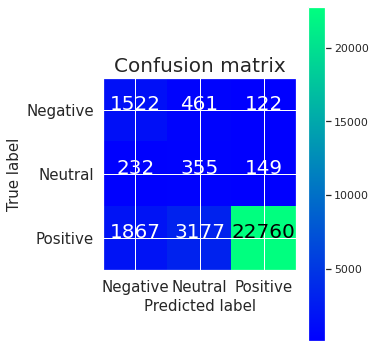

In [ ]:
model_count_tfidf(MultinomialNB,X_train_balance, y_train_balance, X_test, y_test)

The classifier is RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False) 

              precision    recall  f1-score   support

    Negative       0.34      0.88      0.49      2105
     Neutral       0.06      0.14      0.09       736
    Positive       0.99      0.83      0.90     27804

    accuracy                           0.82     30645
   macro avg       0.46      0.62      0.49     30645
weighted avg       0.92      0.82      0.85     30645

The Kappa score is 0.3783443937265465


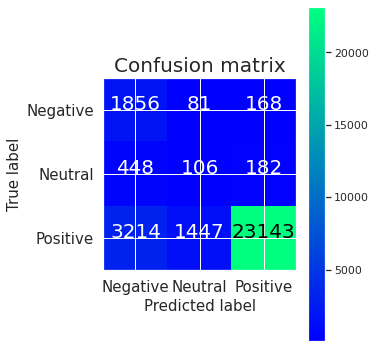

In [ ]:
model_count_tfidf(RandomForestClassifier, X_train_balance, y_train_balance, X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


The classifier is LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) 

              precision    recall  f1-score   support

    Negative       0.42      0.81      0.55      2105
     Neutral       0.09      0.38      0.15       736
    Positive       0.99      0.84      0.91     27804

    accuracy                           0.83     30645
   macro avg       0.50      0.68      0.54     30645
weighted avg       0.93      0.83      0.86     30645

The Kappa score is 0.39908764121428497


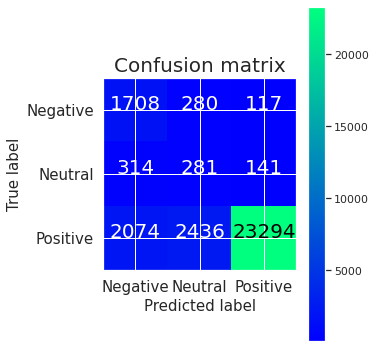

In [ ]:
bigrams(LogisticRegression,X_train_balance, y_train_balance, X_test, y_test)

The classifier is MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) 

              precision    recall  f1-score   support

    Negative       0.41      0.77      0.53      2105
     Neutral       0.09      0.47      0.14       736
    Positive       0.99      0.81      0.89     27804

    accuracy                           0.80     30645
   macro avg       0.49      0.68      0.52     30645
weighted avg       0.93      0.80      0.85     30645

The Kappa score is 0.3582556700774079


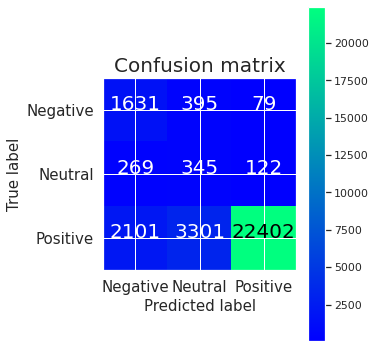

In [ ]:
bigrams(MultinomialNB,X_train_balance, y_train_balance, X_test, y_test)

The classifier is RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False) 

              precision    recall  f1-score   support

    Negative       0.40      0.86      0.55      2267
     Neutral       0.06      0.12      0.08       688
    Positive       0.98      0.87      0.92     27690

    accuracy                           0.85     30645
   macro avg       0.48      0.62      0.52     30645
weighted avg       0.92      0.85      0.87     30645

The Kappa score is 0.43


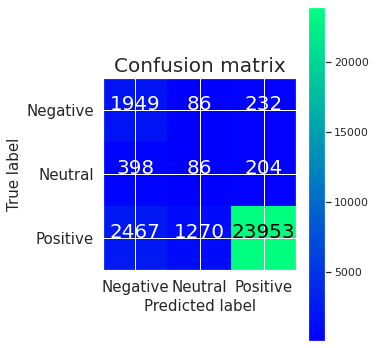

In [361]:
bigrams(RandomForestClassifier,X_train_balance, y_train_balance, X_test, y_test)

## Performing grid search cross validation to improve the model

In [ ]:
from sklearn.model_selection import GridSearchCV
tfidf_vect = TfidfVectorizer(ngram_range = (1,2), analyzer='word', token_pattern=r'\w{1,}', max_features=100000)
tfidf_vect.fit(X_train_balance)
xtrain_tfidf =  tfidf_vect.transform(X_train_balance)
#xtest_tfidf =  tfidf_vect.transform(X_test)
param_grid = {
    'n_estimators': [50, 100], 
    'min_samples_split': [2, 4], 
    'min_samples_leaf' : [1, 2],
    'max_features': ['sqrt']
    }

clf = RandomForestClassifier(random_state=100)

grid_search = GridSearchCV(clf, param_grid, cv=5,return_train_score=True, verbose = 20)
grid_search.fit(xtrain_tfidf,y_train_balance)
grid_search.best_params_ #To check the best set of parameters returned

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=(train=0.988, test=0.882), total= 1.0min
[CV] max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min remaining:    0.0s


[CV]  max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=(train=0.988, test=0.877), total= 1.0min
[CV] max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.0min remaining:    0.0s


[CV]  max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=(train=0.988, test=0.870), total= 1.0min
[CV] max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.0min remaining:    0.0s


[CV]  max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=(train=0.988, test=0.873), total= 1.0min
[CV] max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  4.1min remaining:    0.0s


[CV]  max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=(train=0.988, test=0.880), total=  59.6s
[CV] max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.1min remaining:    0.0s


[CV]  max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=(train=0.988, test=0.887), total= 2.0min
[CV] max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  7.1min remaining:    0.0s


[CV]  max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=(train=0.988, test=0.881), total= 2.0min
[CV] max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  9.1min remaining:    0.0s


[CV]  max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=(train=0.988, test=0.873), total= 2.0min
[CV] max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 11.2min remaining:    0.0s


[CV]  max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=(train=0.988, test=0.880), total= 2.0min
[CV] max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 13.2min remaining:    0.0s


[CV]  max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=(train=0.988, test=0.883), total= 2.0min
[CV] max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=50 


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 15.2min remaining:    0.0s


[CV]  max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=50, score=(train=0.987, test=0.882), total=  49.1s
[CV] max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=50 


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed: 16.0min remaining:    0.0s


[CV]  max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=50, score=(train=0.988, test=0.880), total=  48.6s
[CV] max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=50 


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 16.8min remaining:    0.0s


[CV]  max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=50, score=(train=0.988, test=0.872), total=  48.7s
[CV] max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=50 


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed: 17.7min remaining:    0.0s


[CV]  max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=50, score=(train=0.988, test=0.878), total=  49.2s
[CV] max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=50 


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed: 18.5min remaining:    0.0s


[CV]  max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=50, score=(train=0.988, test=0.881), total=  49.2s
[CV] max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=100 


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 19.3min remaining:    0.0s


[CV]  max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=100, score=(train=0.987, test=0.887), total= 1.6min
[CV] max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=100 


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed: 21.0min remaining:    0.0s


[CV]  max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=100, score=(train=0.988, test=0.881), total= 1.6min
[CV] max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=100 


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed: 22.6min remaining:    0.0s


[CV]  max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=100, score=(train=0.988, test=0.873), total= 1.6min
[CV] max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=100 


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 24.3min remaining:    0.0s


[CV]  max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=100, score=(train=0.988, test=0.882), total= 1.6min
[CV] max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=100 


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed: 25.9min remaining:    0.0s


[CV]  max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=100, score=(train=0.988, test=0.882), total= 1.6min
[CV] max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50 
[CV]  max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50, score=(train=0.870, test=0.781), total=  13.8s
[CV] max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50 
[CV]  max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50, score=(train=0.875, test=0.781), total=  13.9s
[CV] max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50 
[CV]  max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50, score=(train=0.873, test=0.780), total=  13.7s
[CV] max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50 
[CV]  max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50, score=(train=0.878, test=0.789), total=  14.3s
[CV] max_features=sqr

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 34.7min finished


{'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 100}

              precision    recall  f1-score   support

    Negative       0.39      0.86      0.54      2170
     Neutral       0.07      0.10      0.08       710
    Positive       0.98      0.88      0.93     27765

    accuracy                           0.86     30645
   macro avg       0.48      0.61      0.52     30645
weighted avg       0.92      0.86      0.88     30645

The Kappa score is 0.4458483218847282


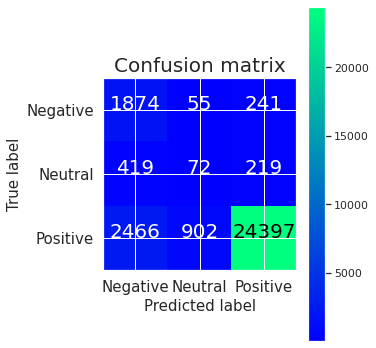

In [ ]:
clf = RandomForestClassifier(random_state=0, max_features='sqrt', min_samples_leaf=1, min_samples_split=4, n_estimators=100)
classification_random = clf.fit(xtrain_tfidf, y_train_balance)
xtest_tfidf =  tfidf_vect.transform(X_test)
pred_y = classification_random.predict(xtest_tfidf)
cm_random = confusion_matrix(y_test,pred_y)


print(classification_report(y_test,pred_y))
print('The Kappa score is {}'.format(cohen_kappa_score(y_test,pred_y)))
    
fig = plt.figure(figsize=(5, 5))
plot_random = plot_confusion_matrix(cm_random, classes=['Negative','Neutral','Positive'], normalize=False, title='Confusion matrix')
plt.show()

### Oversampling with SMOTE

### SMOTE with unigram

In [44]:
def smote_model_count_tfidf(classifier, X_train, encoded_Y_train, X_test,encoded_Y_test):
#     for n in classifier:
    tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=100000)
    tfidf_vect.fit(X_train)
    xtrain_tfidf =  tfidf_vect.transform(X_train)
    xtest_tfidf =  tfidf_vect.transform(X_test)
    sm = SMOTE()
    sm_xtrain_tfidf, sm_train_y = sm.fit_sample(xtrain_tfidf, encoded_Y_train)
    classification = classifier().fit(sm_xtrain_tfidf, sm_train_y)
    pred = classification.predict(xtest_tfidf)
    cm = confusion_matrix(encoded_Y_test,pred)


    print(f'The classifier is {classifier()}','\n')
    print(classification_report(encoded_Y_test,pred))
    print('The Kappa score is {:4.2f}'.format(cohen_kappa_score(encoded_Y_test,pred)))
    
    fig = plt.figure(figsize=(5, 5))
    plot = plot_confusion_matrix(cm, classes=['Negative','Neutral','Positive'], normalize=False, title='Confusion matrix')
    plt.show()

In [41]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y_train = encoder.transform(y_train)
encoded_Y_test = encoder.transform(y_test)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train = np_utils.to_categorical(encoded_Y_train)
dummy_y_test = np_utils.to_categorical(encoded_Y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


The classifier is LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) 

              precision    recall  f1-score   support

           0       0.51      0.71      0.59      2149
           1       0.09      0.40      0.15       728
           2       0.98      0.86      0.92     27768

    accuracy                           0.84     30645
   macro avg       0.53      0.66      0.55     30645
weighted avg       0.93      0.84      0.88     30645

The Kappa score is 0.4123057541327496


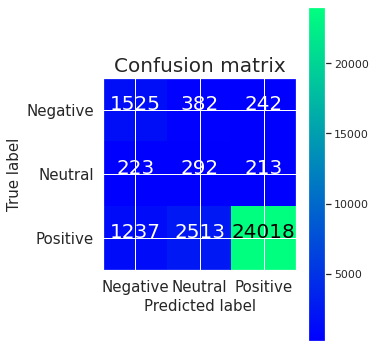

In [68]:
smote_model_count_tfidf(LogisticRegression, X_train, encoded_Y_train, X_test,encoded_Y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


The classifier is MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) 

              precision    recall  f1-score   support

           0       0.45      0.73      0.55      2149
           1       0.10      0.47      0.17       728
           2       0.99      0.85      0.91     27768

    accuracy                           0.83     30645
   macro avg       0.51      0.68      0.55     30645
weighted avg       0.93      0.83      0.87     30645

The Kappa score is 0.40667979496619444


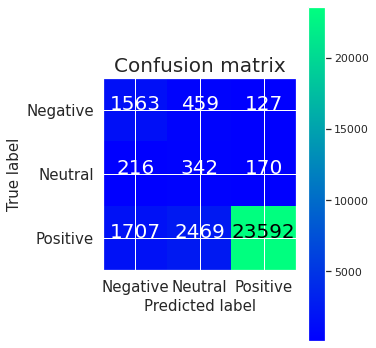

In [67]:
smote_model_count_tfidf(MultinomialNB, X_train, encoded_Y_train, X_test,encoded_Y_test)

In [45]:
#clf = RandomForestClassifier(random_state=0, max_features='sqrt', min_samples_leaf=1, min_samples_split=4, n_estimators=100)
#classification_random = clf.fit(xtrain_tfidf, y_train_balance)
def smote_model_count_tfidf_random(X_train, encoded_Y_train, X_test,encoded_Y_test):
#     for n in classifier:
    tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=100000)
    tfidf_vect.fit(X_train)
    xtrain_tfidf =  tfidf_vect.transform(X_train)
    xtest_tfidf =  tfidf_vect.transform(X_test)
    sm = SMOTE()
    sm_xtrain_tfidf, sm_train_y = sm.fit_sample(xtrain_tfidf, encoded_Y_train)
    clf = RandomForestClassifier(random_state=0, max_features='sqrt', min_samples_leaf=1, min_samples_split=4, n_estimators=100)
    classification_random = clf.fit(sm_xtrain_tfidf, sm_train_y)
    #classification = classifier().fit(sm_xtrain_tfidf, sm_train_y)
    pred = classification_random.predict(xtest_tfidf)
    cm = confusion_matrix(encoded_Y_test,pred)


    #print(f'The classifier is {classifier()}','\n')
    print(classification_report(encoded_Y_test,pred))
    print('The Kappa score is {:4.2f}'.format(cohen_kappa_score(encoded_Y_test,pred)))
    
    fig = plt.figure(figsize=(5, 5))
    plot = plot_confusion_matrix(cm, classes=['Negative','Neutral','Positive'], normalize=False, title='Confusion matrix')
    plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


The classifier is RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False) 

              precision    recall  f1-score   support

           0       0.58      0.68      0.63      2167
           1       0.06      0.07      0.07       717
           2       0.96      0.95      0.95     27761

    accuracy                           0.91     30645
   macro avg       0.53      0.57      0.55     30645
weighted avg       0.91      0.91      0.91     30645

The Kappa score is 0.50


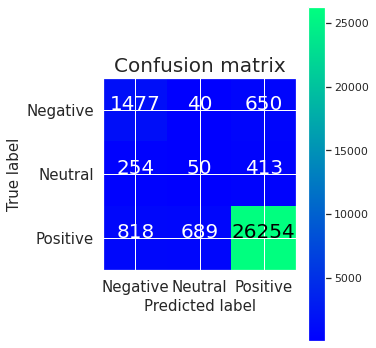

In [46]:
smote_model_count_tfidf(RandomForestClassifier , X_train, encoded_Y_train, X_test,encoded_Y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0       0.58      0.67      0.63      2167
           1       0.07      0.07      0.07       717
           2       0.96      0.95      0.95     27761

    accuracy                           0.91     30645
   macro avg       0.54      0.56      0.55     30645
weighted avg       0.91      0.91      0.91     30645

The Kappa score is 0.50


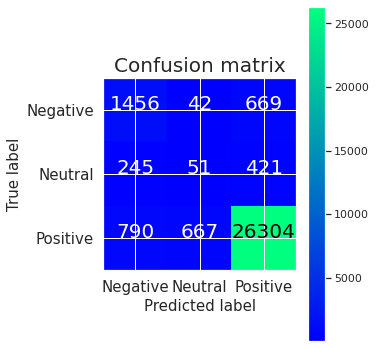

In [47]:
smote_model_count_tfidf_random(X_train, encoded_Y_train, X_test,encoded_Y_test)

### SMOTE with bigrams

In [389]:
def smote_bigrams(classifier, X_train, encoded_Y_train, X_test,encoded_Y_test):
#     for n in classifier:
    tfidf_vect = TfidfVectorizer(ngram_range = (1,2), analyzer='word', token_pattern=r'\w{1,}', max_features=100000)
    tfidf_vect.fit(X_train)
    xtrain_tfidf =  tfidf_vect.transform(X_train)
    xtest_tfidf =  tfidf_vect.transform(X_test)
    sm = SMOTE()
    sm_xtrain_tfidf, sm_train_y = sm.fit_sample(xtrain_tfidf, encoded_Y_train)
    classification = classifier().fit(sm_xtrain_tfidf, sm_train_y)
    pred = classification.predict(xtest_tfidf)
    cm = confusion_matrix(encoded_Y_test,pred)


    print(f'The classifier is {classifier()}','\n')
    print(classification_report(encoded_Y_test,pred))
    print('The Kappa score is {:4.2f}'.format(cohen_kappa_score(encoded_Y_test,pred)))
    
    fig = plt.figure(figsize=(5, 5))
    plot = plot_confusion_matrix(cm, classes=['Negative','Neutral','Positive'], normalize=False, title='Confusion matrix')
    plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


The classifier is MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) 

              precision    recall  f1-score   support

           0       0.48      0.77      0.59      2149
           1       0.13      0.38      0.19       728
           2       0.99      0.89      0.93     27768

    accuracy                           0.87     30645
   macro avg       0.53      0.68      0.57     30645
weighted avg       0.93      0.87      0.89     30645

The Kappa score is 0.47466319114642574


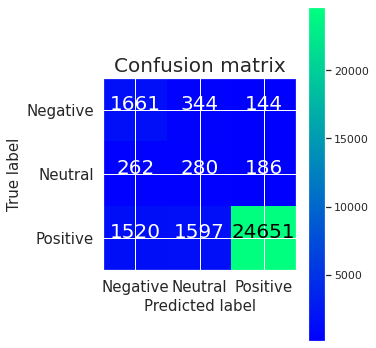

In [77]:
smote_bigrams(MultinomialNB, X_train, encoded_Y_train, X_test,encoded_Y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


The classifier is LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) 

              precision    recall  f1-score   support

           0       0.55      0.75      0.63      2267
           1       0.10      0.27      0.15       688
           2       0.98      0.91      0.94     27690

    accuracy                           0.88     30645
   macro avg       0.54      0.64      0.57     30645
weighted avg       0.93      0.88      0.90     30645

The Kappa score is 0.49


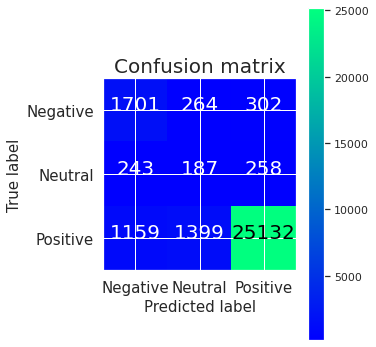

In [390]:
smote_bigrams(LogisticRegression, X_train, encoded_Y_train, X_test,encoded_Y_test)

In [ ]:
smote_bigrams(RandomForestClassifier , X_train, encoded_Y_train, X_test,encoded_Y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## Approach 3: Deep Learning - Convolutional Neural Network with Keras

Word embeddings are a type of word representation that allows words with similar meaning to have a similar representation, individual words are represented as real-valued vectors in a predefined vector space. Each word is mapped to one vector and the vector values are learned in a way that resembles a neural network.

In [376]:
lst_word_train = X_train.map(lambda x: x.split(' '))

In [377]:
#Build training vocabulary and get maximum training sentence length and total number of words training data
all_training_words = [word for tokens in lst_word_train for word in tokens]
training_sentence_lengths = [len(tokens) for tokens in lst_word_train]
TRAINING_VOCAB = sorted(list(set(all_training_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_training_words), len(TRAINING_VOCAB)))
print("Max sentence length is %s" % max(training_sentence_lengths))

1006773 words total, with a vocabulary size of 20027
Max sentence length is 444


In [378]:
lst_word_test = X_test.map(lambda x: x.split(' '))

In [379]:
#Build training vocabulary and get maximum training sentence length and total number of words validation data
all_test_words = [word for tokens in lst_word_test for word in tokens]
test_sentence_lengths = [len(tokens) for tokens in lst_word_test]
TEST_VOCAB = sorted(list(set(all_test_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_test_words), len(TEST_VOCAB)))
print("Max sentence length is %s" % max(test_sentence_lengths))

334580 words total, with a vocabulary size of 11291
Max sentence length is 285


### Tokenize and pad sequences for train set

In [380]:
vocab_size = 20027
encoded_docs = [one_hot(d, vocab_size) for d in X_train]
# pad documents to a max length of 444 words
max_length = 444
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

### Tokenize and pad sequences for test set

In [381]:
encoded_docs_test = [one_hot(a, vocab_size) for a in X_test]
padded_docs_test = pad_sequences(encoded_docs_test, maxlen=max_length, padding='post')

### Modelling

In [382]:
#print(padded_docs)
# define the model
from keras.layers import Dropout
model = Sequential()
model.add(Embedding(vocab_size, 150 , input_length=max_length)) #dimension 150
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(3, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())
# fit the model
model.fit(padded_docs, dummy_y_train,validation_data =(padded_docs_test,dummy_y_test),batch_size=100, epochs=10, verbose=1)
# evaluate the model
loss, accuracy = model.evaluate(padded_docs, dummy_y_train)
print('Accuracy: %f' % (accuracy*100))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 444, 150)          3004050   
_________________________________________________________________
dropout_2 (Dropout)          (None, 444, 150)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 66600)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 199803    
Total params: 3,203,853
Trainable params: 3,203,853
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
920/920 [==============================] - 34s 36ms/step - loss: 0.2766 - accuracy: 0.9158 - val_loss: 0.1910 - val_accuracy: 0.9425
Epoch 2/10
920/920 [==============================] - 33s 36ms/step - loss: 0.1680 - accuracy

              precision    recall  f1-score   support

           0       0.68      0.67      0.67      2267
           1       0.19      0.05      0.08       688
           2       0.96      0.98      0.97     27690

    accuracy                           0.94     30645
   macro avg       0.61      0.57      0.58     30645
weighted avg       0.92      0.94      0.93     30645

The Kappa score is :  0.60


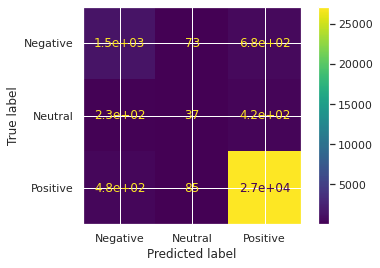

In [385]:
#batch_size=100, epochs=10,Dropout(0.5), epochs=10
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
confusion_matrix(encoded_Y_test,y_pred)
ConfusionMatrixDisplay(confusion_matrix(encoded_Y_test,y_pred), display_labels=['Negative','Neutral','Positive']).plot()
print( classification_report(encoded_Y_test,y_pred))
print('The Kappa score is :  {:4.2f}'.format(cohen_kappa_score(encoded_Y_test, y_pred)))

### Performing Keras on the manually balanced set

In [ ]:
lst_word_train_2 = X_train_balance.map(lambda x: x.split(' '))

In [ ]:
#Build training vocabulary and get maximum training sentence length and total number of words training data
all_training_words_2 = [word for tokens in lst_word_train_2 for word in tokens]
training_sentence_lengths_2 = [len(tokens) for tokens in lst_word_train_2]
TRAINING_VOCAB_2 = sorted(list(set(all_training_words_2)))
print("%s words total, with a vocabulary size of %s" % (len(all_training_words_2), len(TRAINING_VOCAB_2)))
print("Max sentence length is %s" % max(training_sentence_lengths_2))

329212 words total, with a vocabulary size of 12170
Max sentence length is 400


In [ ]:
vocab_size_2 = 12170
encoded_docs_2 = [one_hot(d, vocab_size_2) for d in X_train_balance]
#encoded_docs_test = [one_hot(a, vocab_size) for a in X_test]
# pad documents to a max length of 444 words
max_length_2 = 400
padded_docs_2 = pad_sequences(encoded_docs_2, maxlen=max_length_2, padding='post')

In [ ]:
encoded_docs_test_2 = [one_hot(a, vocab_size_2) for a in X_test]
padded_docs_test_2 = pad_sequences(encoded_docs_test_2, maxlen=max_length_2, padding='post')

In [ ]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train_balance)
encoded_Y_train_2 = encoder.transform(y_train_balance)
#encoded_Y_test = encoder.transform(y_test)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train_2 = np_utils.to_categorical(encoded_Y_train_2)
#dummy_y_test = np_utils.to_categorical(encoded_Y_test)

In [ ]:
#print(padded_docs)
# define the model
from keras.layers import Dropout
model_2 = Sequential()
model_2.add(Embedding(vocab_size_2, 500 , input_length=max_length_2))
model_2.add(Dropout(0.5))
model_2.add(Flatten())
model_2.add(Dense(3, activation='sigmoid'))
# compile the model
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# summarize the model
print(model_2.summary())
# fit the model
model_2.fit(padded_docs_2, dummy_y_train_2,validation_data =(padded_docs_test_2,dummy_y_test),batch_size=50, epochs=10, verbose=1)
# evaluate the model
loss2, accuracy2 = model_2.evaluate(padded_docs_2, dummy_y_train_2)
print('Accuracy: %f' % (accuracy2*100))

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 400, 500)          6085000   
_________________________________________________________________
dropout_12 (Dropout)         (None, 400, 500)          0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 200000)            0         
_________________________________________________________________
dense_18 (Dense)             (None, 3)                 600003    
Total params: 6,685,003
Trainable params: 6,685,003
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
395/395 [==============================] - 35s 89ms/step - loss: 0.9558 - accuracy: 0.5514 - val_loss: 0.4503 - val_accuracy: 0.8590
Epoch 2/10
395/395 [==============================] - 35s 88ms/step - loss: 0.4021 - accurac

958/958 [==============================] - 6s 6ms/step
              precision    recall  f1-score   support

           0       0.34      0.84      0.49      2105
           1       0.08      0.18      0.11       736
           2       0.98      0.84      0.91     27804

    accuracy                           0.82     30645
   macro avg       0.47      0.62      0.50     30645
weighted avg       0.92      0.82      0.86     30645

0.3789829519192315


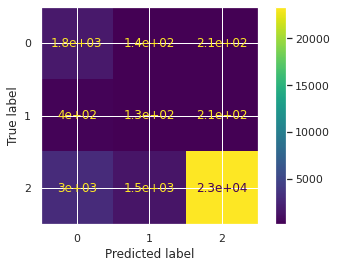

In [ ]:
test_predictions_2 = model_2.predict(padded_docs_test_2,verbose=1)
y_pred_2 = np.argmax(test_predictions_2, axis=-1)
confusion_matrix(encoded_Y_test,y_pred_2)
ConfusionMatrixDisplay(confusion_matrix(encoded_Y_test,y_pred_2), display_labels=['0','1','2']).plot()
print(classification_report(encoded_Y_test,y_pred_2))
print(cohen_kappa_score(encoded_Y_test, y_pred_2))

Among different model that we have performed so far, the Logistic Regression using Unigrams gives the best result. However, we need to try hyperparameter on Convolutional Neural Network and give different range of parameters for the Grid Search to improve Random Forest model.